In [1]:
import numpy as np
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import skew
import matplotlib.pyplot as plt



import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

from xgboost import XGBRegressor

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression


import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import os
import keras


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random as rng


Using TensorFlow backend.


In [2]:
#Divede the train, validation and test dataset.
file_handler = open("../pairsDevTrain.txt", "r", encoding="utf-8")

# We must first put the data in a list
train_same = [];
train_diff= [];

for row in file_handler:
    # The values we read are strings, we must convert them to the correct type (float)
    temp=row.replace("\n", "");
    string= temp.split("\t") # split it by whitespace
    converted = [x for x in string]
    if len(converted) ==3:
        #train_same.append( [converted[0],converted[1],converted[0],converted[2] ]);
        train_same.append( converted );
    if len(converted) ==4:
        train_diff.append(converted);
file_handler.close()


file_handler = open("../pairsDevTest.txt", "r", encoding="utf-8")
# We must first put the data in a list
test_same = [];
test_diff= [];

for row in file_handler:
    temp=row.replace("\n", "");
    string= temp.split("\t") # split it by whitespace
    converted = [x for x in string]
    if len(converted) ==3:
        test_same.append( converted );
    if len(converted) ==4:
        test_diff.append(converted);
file_handler.close()

print("There are {} images in the train, {} in the test".format(len(train_same)+ len(train_diff), len(test_same)+ len(test_diff) ) );


vali_same= test_same[0: len(test_same)//2];
test_same= test_same[len(test_same)//2: ];

vali_diff= test_diff[0: len(test_diff)//2];  #notice: should be test_diff
test_diff= test_diff[len(test_diff)//2: ];

There are 2200 images in the train, 1000 in the test


In [4]:
len( train_same), len(train_diff), len(vali_same), len(vali_diff), len(test_same), len(test_diff)

(1100, 1100, 250, 250, 250, 250)

In [3]:
def format_filename(name, number):
    num_zeros = "0"*(4 - len(number))
    filepath = "../lfw2/"+name+"/"+name+"_"+num_zeros+number+".jpg"
    return filepath

In [4]:

def get_batch(batch_size, same, diff):
    # initialize 2 empty arrays for the input image batch
    img=mpimg.imread( format_filename( same[0][0], same[0][1] )  );
    h,w= img.shape;
    pairs=[np.zeros( (batch_size, h, w,1) ) for i in range(2)]    
    # initialize vector for the targets
    targets=np.zeros( batch_size )

    for i in range( batch_size//2 ):
        img1=mpimg.imread( format_filename( same[i][0], same[i][1] )  );
        img2=mpimg.imread( format_filename( same[i][0], same[i][2] )  );
        pairs[0][i, :, :, :]= img1.reshape( (h, w, 1) );
        pairs[1][i, :, :, :]= img2.reshape( (h, w, 1) );
        targets[i]= 1;
    for i in range( batch_size//2, batch_size ):
        j= i- batch_size//2;
        img1=mpimg.imread(format_filename(diff[j][0], diff[j][1] )  );
        img2=mpimg.imread(format_filename(diff[j][2], diff[j][3] )  );
        pairs[0][i, :, :, :]= img1.reshape( (h, w, 1) );
        pairs[1][i, :, :, :]= img2.reshape( (h, w, 1) );
        targets[i]= 0;
    
    return pairs, targets

In [5]:
train_X, train_y= get_batch(100, train_same, train_diff);
vali_X, vali_y= get_batch(50, vali_same, vali_diff);
test_X, test_y= get_batch(50, test_same, test_diff);



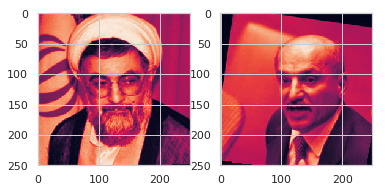

In [6]:
plt.subplot(121)
plt.imshow(vali_X[0][-1, :, :, :].reshape(250, 250) );
plt.subplot(122)
plt.imshow(vali_X[1][-1, :, :, :].reshape(250, 250) );

In [7]:
for i in range(2):
    train_X[i] = train_X[i].astype('float32')
    test_X[i] = test_X[i].astype('float32')
    vali_X[i] = vali_X[i].astype('float32')
    train_X[i] = train_X[i] / 255.
    vali_X[i] = vali_X[i] / 255.
    test_X[i] = test_X[i] / 255.

train_y= train_y.reshape( ( len(train_y), 1 ) );
vali_y= vali_y.reshape( ( len(vali_y),1 ) );
test_y= test_y.reshape( ( len(test_y),1 ) );

In [8]:
train_X[0].shape, train_y.shape, vali_X[1].shape, vali_y.shape

((100, 250, 250, 1), (100, 1), (50, 250, 250, 1), (50, 1))

In [9]:
#Build the model
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Dense, Flatten, Concatenate, Activation,  Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.initializers import RandomNormal, RandomUniform
from keras.regularizers import l1, l2
from keras import backend as K

In [10]:
#Different parameters
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)  
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, (20,20), activation='relu', input_shape=input_shape,
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), 
                   kernel_regularizer=l2(2e-4) ) )
    model.add(MaxPooling2D( (3, 3) ) );
    
    model.add(Conv2D(64, (9,9), activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)  )  )
    model.add(MaxPooling2D( (3, 3)   ))
    
    model.add(Conv2D(128, (4,4), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4) ))
    model.add( MaxPooling2D( (2, 2)  ) )
    
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4) ) )   
    
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),bias_initializer='zeros'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [11]:
#build and compile the model
model= get_siamese_model( [250, 250, 1] );
optimizer = Adam(lr = 0.00006)  #Learning rate was kept low as it was found that with high learning rate, the model took a lot of time to converge.
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy']);
model.summary();

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 250, 250, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         52218848    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

In [12]:
#Train the model
batch_size = 64 #depends on memory
epochs = 20
model_train= model.fit(train_X, train_y, batch_size= batch_size, epochs= epochs, 
                       verbose=1, validation_data=(vali_X, vali_y ) );

Instructions for updating:
Use tf.cast instead.
Train on 100 samples, validate on 50 samples
Epoch 1/20
100/100 [==============================] - 63s 625ms/step - loss: 129.5247 - acc: 0.5000 - val_loss: 129.2193 - val_acc: 0.5200
Epoch 2/20
100/100 [==============================] - 59s 593ms/step - loss: 129.0560 - acc: 0.7800 - val_loss: 128.8303 - val_acc: 0.6000
Epoch 3/20
100/100 [==============================] - 60s 595ms/step - loss: 128.5881 - acc: 0.9100 - val_loss: 128.4447 - val_acc: 0.5200
Epoch 4/20
100/100 [==============================] - 59s 594ms/step - loss: 128.1224 - acc: 0.9800 - val_loss: 128.0314 - val_acc: 0.5800
Epoch 5/20
100/100 [==============================] - 59s 593ms/step - loss: 127.6797 - acc: 0.9500 - val_loss: 127.6211 - val_acc: 0.6000
Epoch 6/20
100/100 [==============================] - 59s 595ms/step - loss: 127.2306 - acc: 0.9800 - val_loss: 127.1981 - val_acc: 0.6600
Epoch 7/20
100/100 [==============================] - 59s 587ms/step - lo

In [13]:
#Evaluate the model
test_eval = model.evaluate(test_X, test_y, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

50/50 [==============================] - 9s 182ms/step
Test loss: 121.31332916259765
Test accuracy: 0.6599999952316284


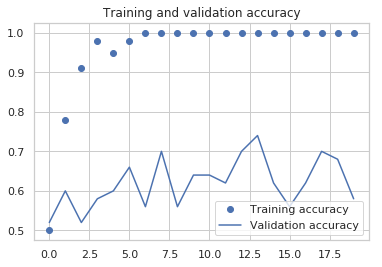

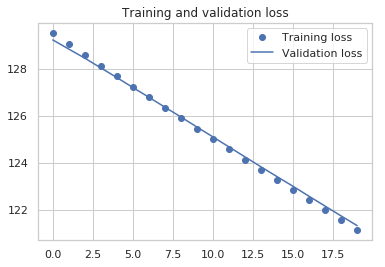

In [15]:
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
#Predit labels
predicted_classes = model.predict(test_X);
predicted_classes= np.round( predicted_classes)
predicted_classes.shape, test_y.shape

Found 33 correct labels


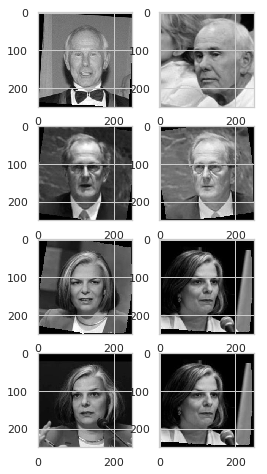

In [31]:
#predicted_classes= predicted_classes.reshape( len(predicted_classes) )
correct = np.where(predicted_classes==test_y)[0]
height, width= (250, 250);

print ("Found %d correct labels" % len(correct) )

plt.figure(figsize= [4,8])
for i, index in enumerate( correct[0: 4]):
    plt.subplot(4, 2, 2*i+1);
    plt.imshow(test_X[0][index].reshape(height, width), cmap="gray");
    
    plt.subplot(4, 2, 2*i+2);
    plt.imshow(test_X[1][index].reshape(height, width), cmap="gray");
    #plt.tight_layout()

Found 17 incorrect labels


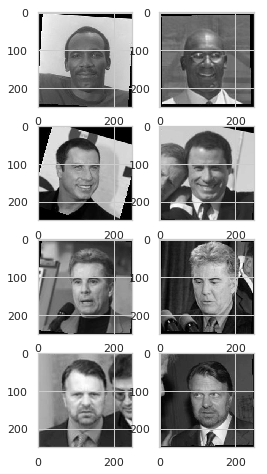

In [35]:
incorrect = np.where(predicted_classes!=test_y)[0]
print ("Found %d incorrect labels" % len(incorrect) )
height, width= (250, 250);

plt.figure(figsize= [4,8])
for i, index in enumerate( incorrect[0: 4]):
    plt.subplot(4, 2, 2*i+1);
    plt.imshow(test_X[0][index].reshape(height, width), cmap="gray");
    
    plt.subplot(4, 2, 2*i+2);
    plt.imshow(test_X[1][index].reshape(height, width), cmap="gray");
    #plt.tight_layout()
    

In [36]:
#This seems to be non-necessary because the training is not overfitting.
#Prevent overfitting with dropout
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)  
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, (20,20), activation='relu', input_shape=input_shape,
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), 
                   kernel_regularizer=l2(2e-4) ) )
    model.add(MaxPooling2D( (3, 3) ) );
    model.add( Dropout(rate=0.25, noise_shape=None, seed=None) );
    
    model.add(Conv2D(64, (9,9), activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)  )  )
    model.add(MaxPooling2D( (3, 3)   ))
    model.add( Dropout(rate=0.25, noise_shape=None, seed=None) );
    
    model.add(Conv2D(128, (4,4), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4) ))
    model.add( MaxPooling2D( (2, 2)  ) )
    model.add( Dropout(rate=0.25, noise_shape=None, seed=None) );
    
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4) ) )   
    
    model.add(Flatten())
    model.add( Dropout(rate=0.25, noise_shape=None, seed=None) );
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),bias_initializer='zeros'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [37]:
#build and compile the new model
model_dropout= get_siamese_model( [250, 250, 1] );
optimizer = Adam(lr = 0.00006)  #Learning rate was kept low as it was found that with high learning rate, the model took a lot of time to converge.
model_dropout.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy']);
model_dropout.summary();

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 250, 250, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 250, 250, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         52218848    input_3[0][0]                    
                                                                 input_4[0][0]                    
_____________________________________________________________________________________________

In [38]:
#Train the model
batch_size = 64 #depends on memory
epochs = 20
model_train_dropout= model_dropout.fit(train_X, train_y, batch_size= batch_size, epochs= epochs, 
                       verbose=1, validation_data=(vali_X, vali_y ) );

Train on 100 samples, validate on 50 samples
Epoch 1/20
100/100 [==============================] - 66s 663ms/step - loss: 129.5914 - acc: 0.4200 - val_loss: 129.3494 - val_acc: 0.6000
Epoch 2/20
100/100 [==============================] - 61s 609ms/step - loss: 129.2947 - acc: 0.5100 - val_loss: 129.0923 - val_acc: 0.5600
Epoch 3/20
100/100 [==============================] - 60s 597ms/step - loss: 129.0414 - acc: 0.5700 - val_loss: 128.8256 - val_acc: 0.6200
Epoch 4/20
100/100 [==============================] - 60s 599ms/step - loss: 128.8129 - acc: 0.5200 - val_loss: 128.5569 - val_acc: 0.6000
Epoch 5/20
100/100 [==============================] - 60s 604ms/step - loss: 128.5721 - acc: 0.4500 - val_loss: 128.2859 - val_acc: 0.5800
Epoch 6/20
100/100 [==============================] - 60s 601ms/step - loss: 128.2966 - acc: 0.4700 - val_loss: 128.0168 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 61s 613ms/step - loss: 128.0289 - acc: 0.4900 - val_loss: 127.7506 

In [39]:
#Evaluate the model
test_eval = model_dropout.evaluate(test_X, test_y, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

50/50 [==============================] - 9s 185ms/step
Test loss: 124.31649597167969
Test accuracy: 0.46


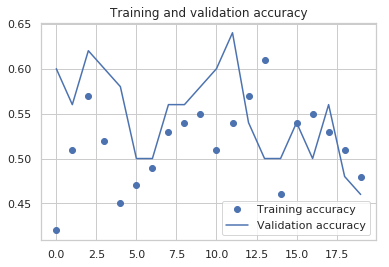

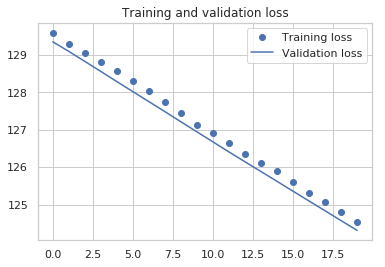

In [40]:
#loss and metric as a function of epoches.
accuracy = model_train_dropout.history['acc']
val_accuracy = model_train_dropout.history['val_acc']
loss = model_train_dropout.history['loss']
val_loss = model_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
#Predit labels
predicted_classes = model_dropout.predict(test_X);
predicted_classes= np.round( predicted_classes)
predicted_classes.shape, test_y.shape

((50, 1), (50, 1))

In [ ]:
#predicted_classes= predicted_classes.reshape( len(predicted_classes) )
correct = np.where(predicted_classes==test_y)[0]
height, width= (250, 250);

print ("Found %d correct labels" % len(correct) )

plt.figure(figsize= [4,8])
for i, index in enumerate( correct[0: 4]):
    plt.subplot(4, 2, 2*i+1);
    plt.imshow(test_X[0][index].reshape(height, width), cmap="gray");
    
    plt.subplot(4, 2, 2*i+2);
    plt.imshow(test_X[1][index].reshape(height, width), cmap="gray");
    #plt.tight_layout()

In [ ]:
incorrect = np.where(predicted_classes!=test_y)[0]
print ("Found %d incorrect labels" % len(incorrect) )
height, width= (250, 250);

plt.figure(figsize= [4,8])
for i, index in enumerate( incorrect[0: 4]):
    plt.subplot(4, 2, 2*i+1);
    plt.imshow(test_X[0][index].reshape(height, width), cmap="gray");
    
    plt.subplot(4, 2, 2*i+2);
    plt.imshow(test_X[1][index].reshape(height, width), cmap="gray");
    #plt.tight_layout()
    

In [9]:
#With 5 convolution layers, maybe too complicated 
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)  
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, (21,21), activation='relu', input_shape=input_shape,
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), kernel_regularizer=l2(2e-4) ,padding='same' ) )
    model.add(MaxPooling2D( (2, 2) , padding='same' ) );
    
    model.add(Conv2D(64, (10,10), activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4),padding='same'  )  )
    model.add(MaxPooling2D( (2, 2) , padding='same'  ))
    
    model.add(Conv2D(128, (8,8), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4),padding='same'))
    model.add( MaxPooling2D( (2, 2) , padding='same'  ) )
    
    model.add(Conv2D(128, (4,4), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4),padding='same'))
    model.add( MaxPooling2D( (2, 2) , padding='same'  ) )
    
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),
                     bias_initializer='zeros', kernel_regularizer=l2(2e-4),padding='same' ) )   
    
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None),bias_initializer='zeros'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net